In [2]:
# read j3 wrf ts files

import os
os.environ['PROJ_LIB'] = '/home/jlee/.conda/envs/mmc_sgp/share/proj'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import mmctools
from mmctools.wrf.utils_solar import Tower
from dateutil import parser
import datetime
from mmctools.plotting import TaylorDiagram
import matplotlib.colors as mcolors

obs_dir = '/projects/mmcpnnl/sgp_obs/'
wrf_runs_dir = '/projects/mmcpnnl/jlee/wrf-mmc/sgp/'
nb_dir = !pwd

# time step of wrf runs
d02_wrf_dt = 10
d03_wrf_dt = 2
d04_wrf_dt = 0.4

# tower location & domain number to analyze
sim_dict = {'meso': ['c1.d02', d02_wrf_dt], 
            'les200m': ['c1.d03', d03_wrf_dt], 
            'les40m': ['c1.d04', d04_wrf_dt]}

# get specific dates associated w/ wrf runs
data_dir_df = pd.read_csv(nb_dir[0]+'/data-dir-j3leswrf.csv', index_col=0)

# obs
co2flx25m_ncs = obs_dir+'sgpco2flx25mC1/*.nc'
# obs bowen_ratio is nan...!

co2flx25m = xr.open_mfdataset(co2flx25m_ncs)

# plotting variables
co2flx25m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)']}

co2flx4m_ncs = obs_dir+'sgpco2flx4mC1.b1/*.nc'
co2flx4m = xr.open_mfdataset(co2flx4m_ncs)
co2flx4m_dict = {'hfx': ['sensible_heat_flux', r'sensible heat flux (W m$^{-2}$)'], 
                 'lh': ['latent_heat_flux', 'latent']}

# 1 obs height in m, to match wrf's heights
share_height = [4, 25]

In [3]:
data_dir_df

,2018-08-05,2018-09-01
mynn,l1_0805m,l3_0901m
edmf,l2_0805e,l4_0901e
mynn_1arcs,l5_0805m,NaN
wrf_start,8/4/18 12:00,8/31/18 12:00


In [5]:
def read_tower_to_ds(tower, wrf_start, dt): 

    ds = tower.to_xarray(start_time=wrf_start, time_step=dt, structure='unordered', 
                         heights=share_height, 
                         height_var='ph', agl=True)

    return ds

def plot_flux(eval_date, row, model):

    date_col = data_dir_df[eval_date]

#     wrf_mynn_dir = wrf_runs_dir+date_col['mynn']+'/'
#     c1_mynn_file_path = wrf_mynn_dir+c1_file_name
    
    wrf_dir = wrf_runs_dir+date_col[row]+'/'
    c1_file_path = wrf_dir+'z_ts/z.'+sim_dict[model][0]
    wrf_tower = Tower(c1_file_path)

    # # simulation start time
    wrf_start = date_col['wrf_start']

    wrf_ds = read_tower_to_ds(wrf_tower, wrf_start, sim_dict[model][1])

    wrf_ds = wrf_ds.sel(datetime=slice(eval_date, eval_date))

    co2flx25m_ds = co2flx25m.sel(time=slice(eval_date, eval_date))
    co2flx4m_ds = co2flx4m.sel(time=slice(eval_date, eval_date))

    for wrf_var, var in co2flx25m_dict.items(): 
        
#         print(wrf_ds['datetime'])
#         print(co2flx25m_ds['time'])

        plt.plot(wrf_ds['datetime'], wrf_ds[wrf_var], label='wrf')
        plt.plot(co2flx25m_ds['time'], co2flx25m_ds[var[0]], label='co2flx25m')

        plt.title(var[0]+': '+row+' '+model+' vs '+co2flx25m_ds.platform_id+': '+eval_date)
        plt.ylabel(var[1])
        plt.axhline(color='grey', linestyle='--')
        plt.tick_params(labelrotation=90)
        plt.legend()

        plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+wrf_var+'.pdf')

        plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for var, ax_i in zip(co2flx4m_dict.items(), ax): 

        ax_i.plot(wrf_ds['datetime'], wrf_ds[var[0]], label='wrf')
        ax_i.plot(co2flx4m_ds['time'], co2flx4m_ds[var[1][0]], label='co2flx4m')

        ax_i.set_title(var[1][0]+': '+row+' '+model+' vs '
                       +co2flx4m_ds.platform_id+': '+eval_date)
        ax_i.set_ylabel(var[1][1])
        ax_i.axhline(color='grey', linestyle='--')
        ax_i.tick_params(labelrotation=90)
        ax_i.legend()

    p2_txt = '_'.join([str(elem) for elem in list(co2flx4m_dict.keys())])    

    plt.savefig('plots_03c/'+eval_date+'_'+row+'_'+model+'_'+p2_txt+'.pdf')

    plt.show()
    
    return wrf_ds

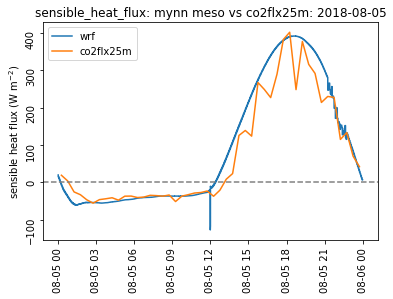

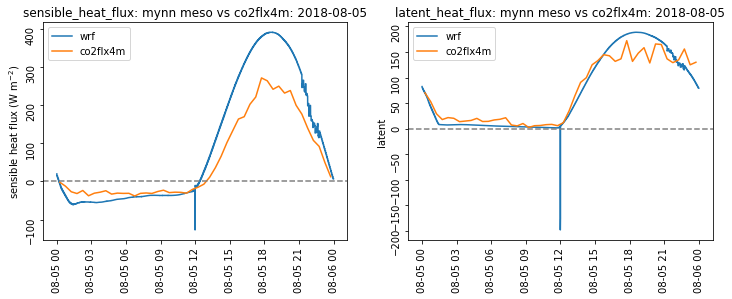

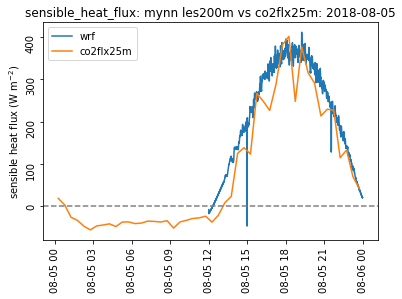

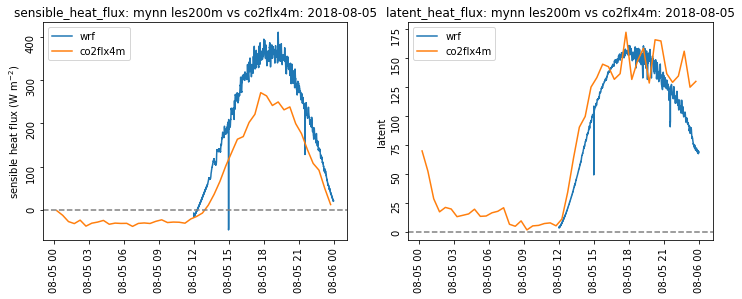

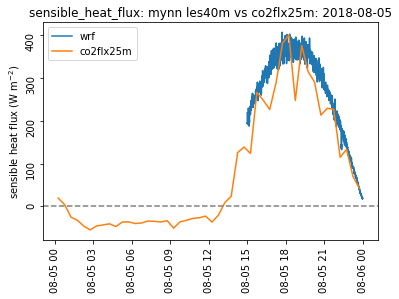

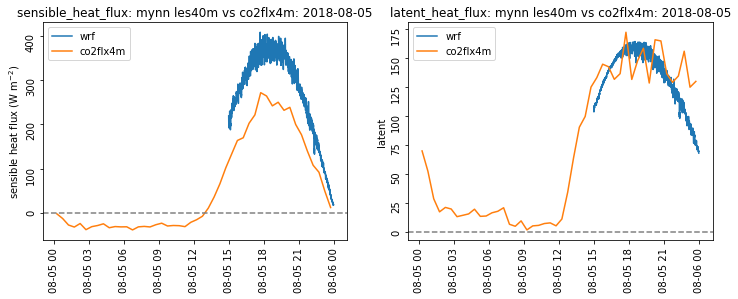

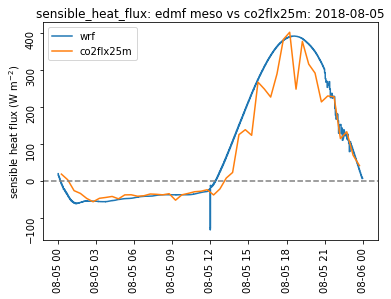

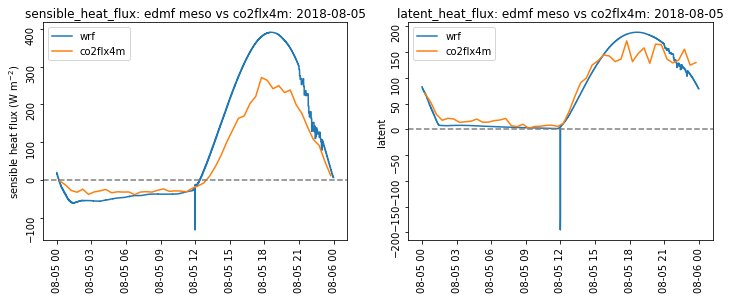

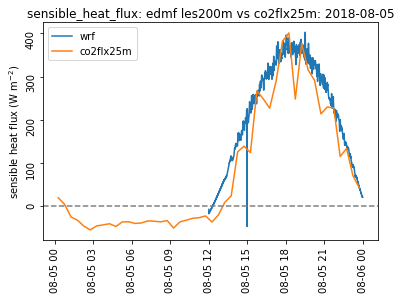

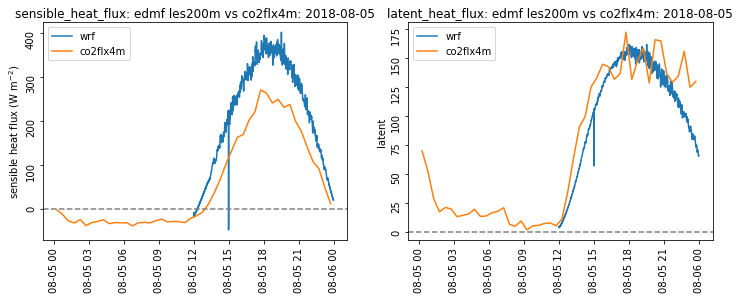

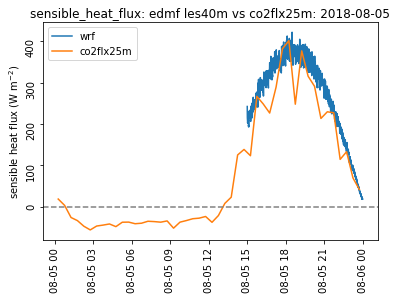

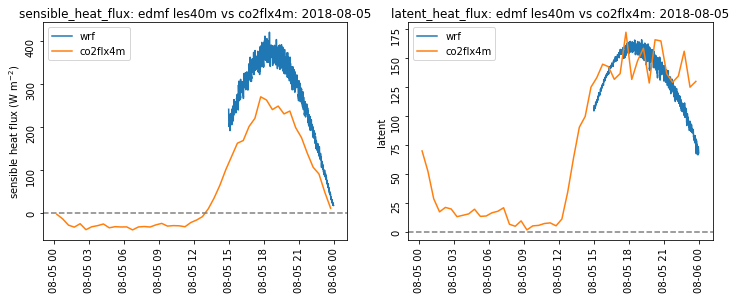

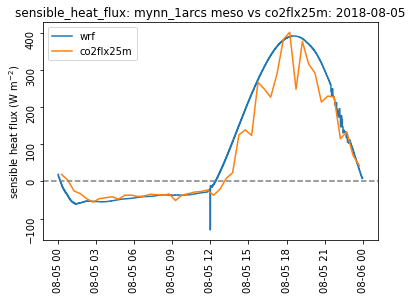

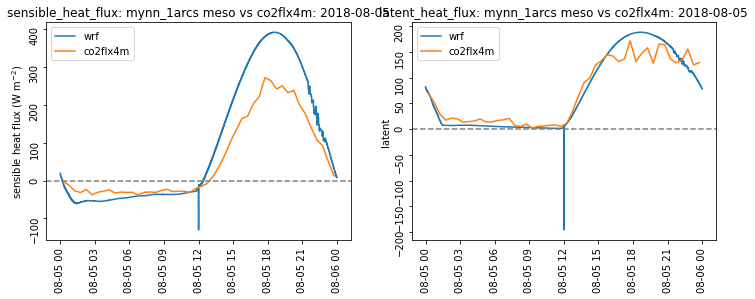

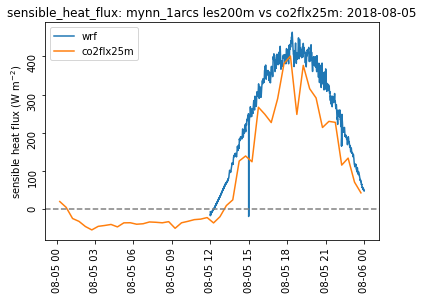

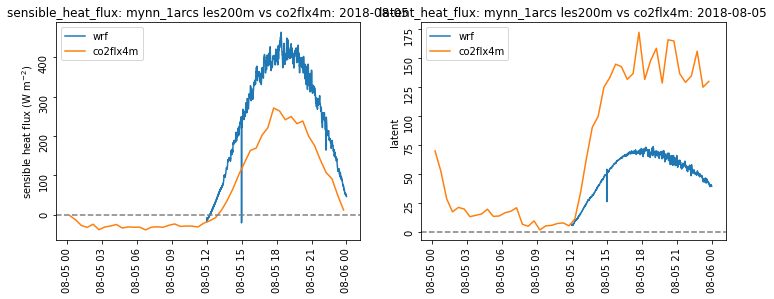

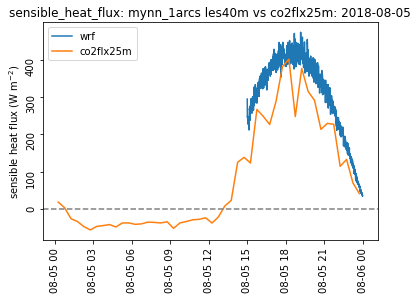

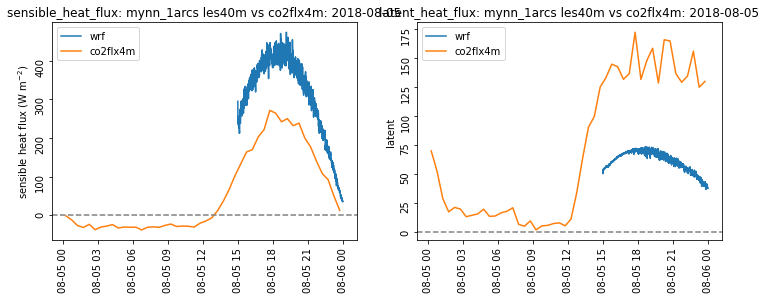

In [36]:
eval_date = '2018-08-05'
for row in ['mynn', 'edmf', 'mynn_1arcs']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

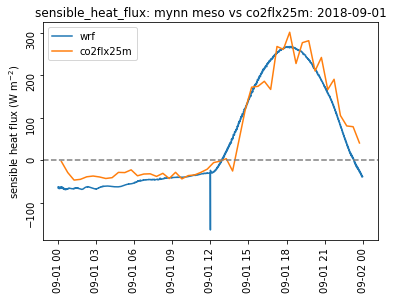

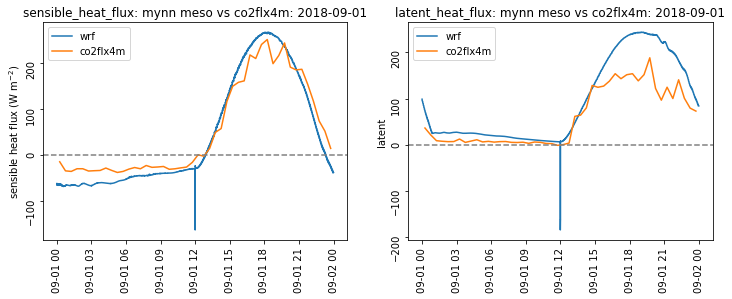

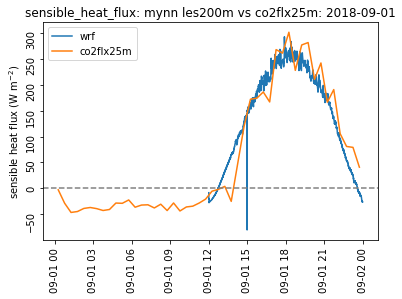

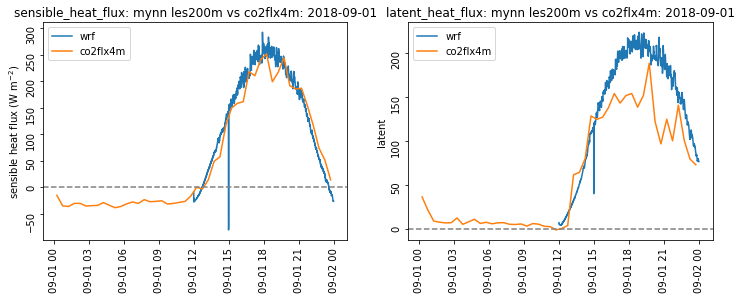

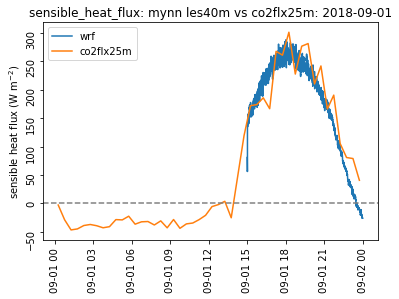

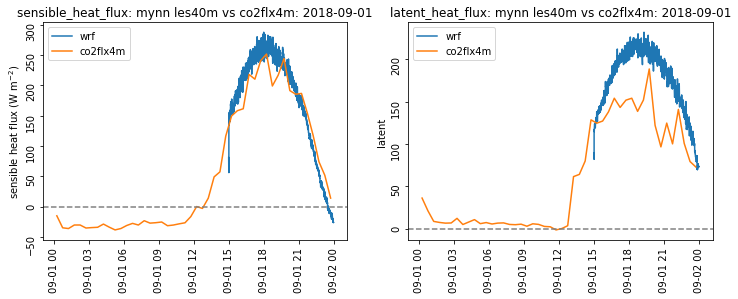

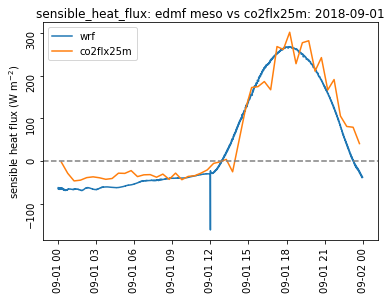

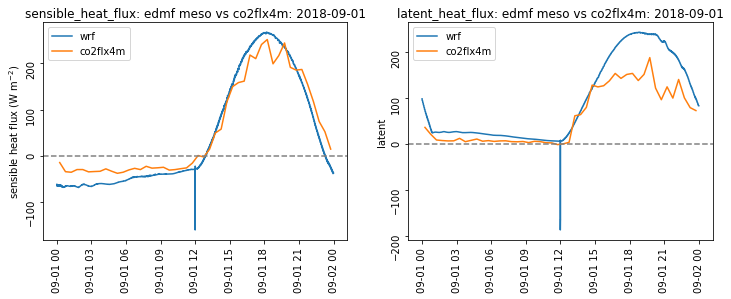

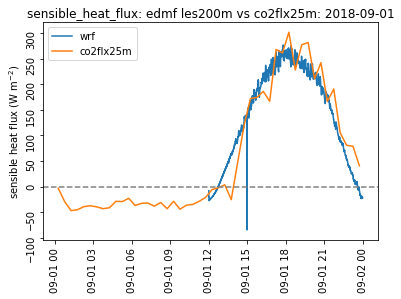

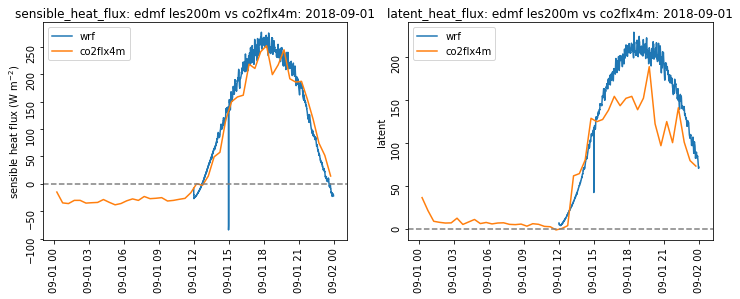

In [ ]:
eval_date = '2018-09-01'
for row in ['mynn', 'edmf']: 
    for model in sim_dict.keys():
        plot_flux(eval_date, row, model)

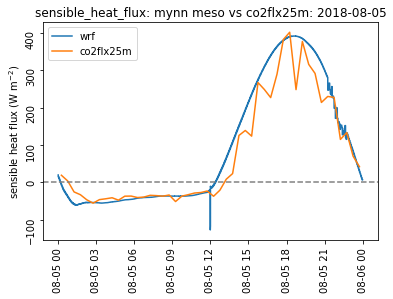

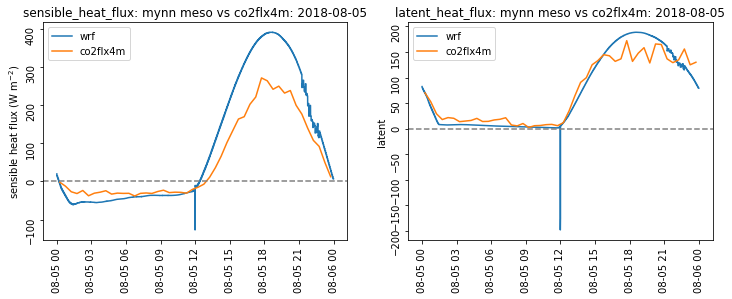

In [18]:
eval_date = '2018-08-05'
mm = plot_flux(eval_date, 'mynn', 'meso')

In [29]:
# checked TS file, hfx IS that odd... starting the inner domain causes the problem??
mm['hfx'].sel(datetime=slice('2018-08-05T11:58', '2018-08-05T12:02'))

<xarray.DataArray 'hfx' (datetime: 30, station: 1)>
array([[ -19.49589],
       [ -19.5514 ],
       [ -19.5992 ],
       [ -19.64952],
       [ -19.70514],
       [ -19.7481 ],
       [ -19.79265],
       [ -19.84283],
       [-127.10773],
       [-116.67835],
       [-117.7855 ],
       [-118.25767],
       [-117.96146],
       [ -10.34582],
       [ -11.78806],
       [ -12.14938],
       [ -12.42465],
       [ -12.70046],
       [ -12.95655],
       [ -13.19956],
       [ -13.43283],
       [ -13.62916],
       [ -13.83105],
       [ -14.02229],
       [ -14.21196],
       [ -14.37398],
       [ -14.54752],
       [ -14.70349],
       [ -14.85901],
       [ -15.00641]])
Coordinates:
  * datetime  (datetime) datetime64[ns] 2018-08-05T11:58:00 ... 2018-08-05T12...
  * station   (station) <U4 'z.c1'